# Implementação

Esse notebook descreve o processo de implementação do sistema de recomendação de filmes.

## 1 - Análise Exploratória

Nessa primeira parte vamos analisar os dados de entrada, seus valores e seus relacionamentos, para compreender melhor como se comportam e como podem ser usados no sistema de recomendação.

In [1]:
import pandas as pd

pd.set_option('max_columns',500)

In [2]:
df_users = pd.read_csv('../data/raw/ml-1m/users.dat', sep='::', encoding='latin', names=['user_id', 'gender', 'age_group', 'occupation', 'cep'])
df_movies = pd.read_csv('../data/raw/ml-1m/movies.dat', sep='::', encoding='latin', names=['movie_id', 'title', 'genres'])
df_ratings = pd.read_csv('../data/raw/ml-1m/ratings.dat', sep='::', encoding='latin', names=['user_id', 'movie_id', 'rating', 'timestamp'])

/home/fernandosiqueira/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/home/fernandosiqueira/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/home/fernandosiqueira/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by 

Ao total a base de dados é composta de 6 arquivos: 

- movies: informação sobre os filmes
- ratings: nota que cada usuário deu a um filme
- tags: conjunto de tags que cada usuário deu a cada filme
- links: códigos dos filmes nos portais movielens, imdb e themoviedb
- genome-score: relevância de cada tag em um filme
- genome-tags: lista de tags

Ao total a base de dados é composta de 3 arquivos: 

- movies: informação sobre os filmes
- user: informação sobre usuário que deu nota ao filme
- ratings: nota que cada usuário deu a um filme


# 1.1 Pré-processamento

Em um primeiro momento, vamos descrever brevemente os dados analisando informações como tipo das colunas, distribuição dos valores e valores nulos. Essa parte também vamos fazer um pré-processamento nas bases, criando novas features ou removendo registros nulos e inválidos.

In [3]:
import missingno as msno

def data_description(df_data):
    """
    Describe data values

    Parameters
    ----------

    df_data : pandas DataFrame
        Data to be describe

    """  
    
    print(df_data.info())
    display(df_data.describe())
    msno.matrix(df_data, figsize=(5,5))
    display(df_data.head())

### 1.1.1 Movies

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
movie_id    3883 non-null int64
title       3883 non-null object
genres      3883 non-null object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB
None


/home/fernandosiqueira/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,movie_id
count,3883.000000
mean,1986.049446
std,1146.778349
min,1.000000
25%,982.500000
50%,2010.000000
75%,2980.500000
max,3952.000000


,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


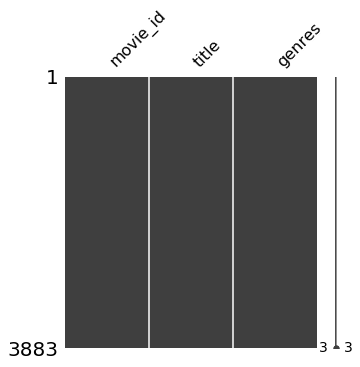

In [53]:
data_description(df_movies)

A base de filmes tem cerca de 3.800 filmes, com informações sobre seu identificador, título e gêneros. O ano do filme está atrelado ao seu título, enquanto o gênero é uma lista de gêneros do filme. Podemos fazer alguns ajustes na tabela de filme:

- Ano: Extrair o ano do nome do filme
- Gênero: Extrair o gênero da lista de gêneros

Para extrair o ano vamos usar o conceito de expressão regular

In [4]:
import re

def extract_year_from_str(string):
    year_pattern = re.compile('.*(\d\d\d\d)')
    year_match = year_pattern.match(string=string)
    
    if year_match:
        return int(year_match.group(1))
    return None

df_movies['year'] = df_movies['title'].apply(extract_year_from_str)
df_movies.head()

,movie_id,title,genres,year
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


Já para extrair os gêneros podemos separar o texto dos gêneros e usar o get_dummies ou One Hot Encoder para transformar as categorias em colunas, separando o texto do gênero pelo caractere "|".

In [5]:
df_genres = pd.get_dummies(df_movies['genres'].str.split('|', expand=True).stack(),  prefix='', prefix_sep='').sum(level=0)
genres = df_genres.columns
df_movies = pd.concat([df_movies, df_genres], axis=1)
df_movies.to_csv('../data/processed/movies_processed.csv', index=False)
df_movies.head()

,movie_id,title,genres,year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama,1995,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,1995,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


### 1.1.2 Users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
user_id       6040 non-null int64
gender        6040 non-null object
age_group     6040 non-null int64
occupation    6040 non-null int64
cep           6040 non-null object
dtypes: int64(3), object(2)
memory usage: 236.0+ KB
None


,user_id,age_group,occupation
count,6040.000000,6040.000000,6040.000000
mean,3020.500000,30.639238,8.146854
std,1743.742145,12.895962,6.329511
min,1.000000,1.000000,0.000000
25%,1510.750000,25.000000,3.000000
50%,3020.500000,25.000000,7.000000
75%,4530.250000,35.000000,14.000000
max,6040.000000,56.000000,20.000000


,user_id,gender,age_group,occupation,cep
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


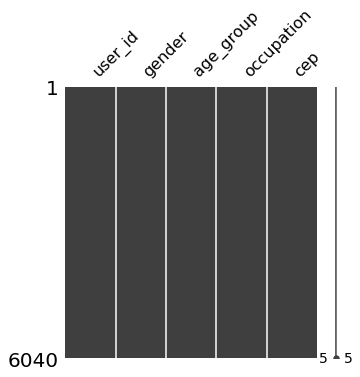

In [20]:
data_description(df_users)

Os 6.000 usuários da base tem informações sobre seu gênero, faixa-etária, profissão e cep. Podemos definir os rótulos do grupo de idade e da profissão para ficar com informações mais amigáveis.

In [6]:
age_group_label = {
    1:  'Under 18',
    18:  '18-24',
    25:  '25-34',
    35:  '35-44',
    45:  '45-49',
    50:  '50-55',
    56:  '56+',
}

occupation_label = {
    0:  'other',
    1:  'academic/educator',
    2:  'artist',
    3:  'clerical/admin',
    4:  'college/grad student',
    5:  'customer service',
    6:  'doctor/health care',
    7:  'executive/managerial',
    8:  'farmer',
    9:  'homemaker',
    10:  'K-12 student',
    11:  'lawyer',
    12:  'programmer',
    13:  'retired',
    14:  'sales/marketing',
    15:  'scientist',
    16:  'self-employed',
    17:  'technician/engineer',
    18:  'tradesman/craftsman',
    19:  'unemployed',
    20:  'writer',
}

df_users['age_group_label'] = df_users['age_group'].map(age_group_label)
df_users['occupation_label'] = df_users['occupation'].map(occupation_label)
df_users.to_csv('../data/processed/users_processed.csv', index=False)
df_users.head()

,user_id,gender,age_group,occupation,cep,age_group_label,occupation_label
0,1,F,1,10,48067,Under 18,K-12 student
1,2,M,56,16,70072,56+,self-employed
2,3,M,25,15,55117,25-34,scientist
3,4,M,45,7,02460,45-49,executive/managerial
4,5,M,25,20,55455,25-34,writer


## 1.1.3 Rattings

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
user_id      1000209 non-null int64
movie_id     1000209 non-null int64
rating       1000209 non-null int64
timestamp    1000209 non-null int64
dtypes: int64(4)
memory usage: 30.5 MB
None


,user_id,movie_id,rating,timestamp
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,9.722437e+08
std,1.728413e+03,1.096041e+03,1.117102e+00,1.215256e+07
min,1.000000e+00,1.000000e+00,1.000000e+00,9.567039e+08
25%,1.506000e+03,1.030000e+03,3.000000e+00,9.653026e+08
50%,3.070000e+03,1.835000e+03,4.000000e+00,9.730180e+08
75%,4.476000e+03,2.770000e+03,4.000000e+00,9.752209e+08
max,6.040000e+03,3.952000e+03,5.000000e+00,1.046455e+09


,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


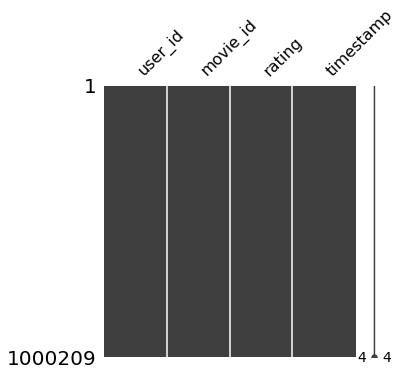

In [23]:
data_description(df_ratings)

A princípio não existe nenhum problema com a tabela de ratings. Não tem dados nulos ou inválidos. Podemos verificar se todos os valores de movie_id e user_id estão presentes em ratings.

In [24]:
df_ratings['movie_id'].isin(df_movies['movie_id']).all()

True

In [25]:
df_ratings['user_id'].isin(df_users['user_id']).all()

True

## 1.1.4 Bônus: Links

Apesar da tabela Links não pertencer originalmente a base de dados ml-1M, ela foi obtida da base ml-20M para efeitos de enriquecimento de dados.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
movieId    27278 non-null int64
imdbId     27278 non-null int64
tmdbId     27026 non-null float64
dtypes: float64(1), int64(2)
memory usage: 639.4 KB
None


,movieId,imdbId,tmdbId
count,27278.000000,2.727800e+04,27026.000000
mean,59855.480570,5.781860e+05,63846.683083
std,44429.314697,7.804707e+05,69862.134497
min,1.000000,5.000000e+00,2.000000
25%,6931.250000,7.741725e+04,15936.500000
50%,68068.000000,1.524350e+05,39468.500000
75%,100293.250000,9.062715e+05,82504.000000
max,131262.000000,4.530184e+06,421510.000000


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


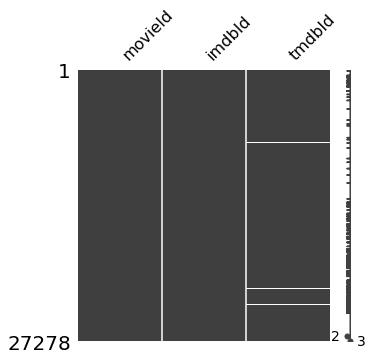

In [7]:
df_links = pd.read_csv('../data/raw/ml-20m/links.csv')
data_description(df_links)

Apesar de ter alguns registros com o tmdbid nulo, ele não é obrigatório para nossa análise. A base, entretanto, tem os 27 mil filmes originais. A base atual tem apenas 6 mil filmes. Logo só iremos necessitar dos filmes contidos na base.



In [6]:
df_links = df_links[df_links['movieId'].isin(df_movies['movie_id'])]

Para complementar a base, podemos buscar as descrições dos filmes do imdb. Como a base do MovieLens precisa de autenticação e a base do TheMovieDB não tem todos filmes, não será capturado as descrições dessas bases, mas poderia fazer um processo de web-scrapping similar.

In [3]:
from lxml import html
import requests
import json

def get_imbd_description(imdbid):
    imdbid = str(imdbid)
    while len(imdbid)<7:
        imdbid='0'+imdbid
    
    r= requests.get('http://www.imdb.com/title/tt{}/'.format(imdbid))
    tree = html.fromstring(r.content)
    try:
        a = tree.xpath('//script[@type="application/ld+json"]/text()')
        return json.loads(a[0])['description']
    except Exception as e:
        return None
    
get_imbd_description(114885)

"Waiting to Exhale is a movie starring Whitney Houston, Angela Bassett, and Loretta Devine. Based on Terry McMillan's novel, this film follows four very different African-American women and their relationships with the male gender."

In [ ]:
#ATENÇÃO: processo leva muito tempo!
#df_link['imdb_description'] = df_link['imdbId'].apply(get_imbd_description)

Com a descrição dos filmes é possível, por exemplo, aplicar técnicas de NLP para identificar similaridades entre filmes.

_________________________________________________

## 2 Análise Exploratória

Após verificar os dados e fazer o pré-processamento, podemos levantar algumas hipóteses para serem validadas na análise exploratória:

#### Filmes com maior número de avaliações tendem a ter notas mais extremas

Filmes famosos são sempre alvo de fãs ou haters. Por isso é de se esperar que filmes com um número maior de avaliações vão apresentar ter dois possíveis cenários:

- O filme será bem avaliado
- O filme terá um desvio padrão maior nas notas

Essa hipótese se baseia na motivação de um usuário dar uma nota a um filme. Explicitar, diretamente, sua opinião um filme requer um engajamento com uma ferramenta, que é motivada, principalmente, por uma paixão ou revolta com o produto consumido.

#### O sexo do usuário influencia no tipo de filme avaliado

Vivemos em uma sociedade patriarcal onde Hollywood, além de não fugir dessa premissa, reforça alguns papéis em suas obras. Logo, existem gêneros de filmes que apelam para públicos específicos. Por exemplo, filmes de romance ou drama usualmente tem características ditas femininas, enquanto filmes de ação e guerra, masculinas.

É de se esperar que tenha diferença tanto no número de avaliações de filmes desses gêneros quanto em notas.





## 2.1 Filmes com maior número de avaliações tendem a ter notas mais extremas

Para validar essa hipóte será preciso calcular o número de avaliações de cada filme e informações sobre suas notas como, por exemplo, nota máxima, mínima, média, mediana e desvio padrão.

In [7]:
import numpy as np

df_hip1 = (
    pd.DataFrame(df_movies[['movie_id', 'title']])
    .set_index('movie_id')
    .merge(df_ratings.groupby('movie_id').agg({'rating':[np.mean, max, min, np.median, np.std, len]})['rating'], left_index=True, right_index=True) 
)

df_hip1.head()

,title,mean,max,min,median,std,len
movie_id,,,,,,,
1,Toy Story (1995),4.146846,5,1,4.0,0.852349,2077
2,Jumanji (1995),3.201141,5,1,3.0,0.983172,701
3,Grumpier Old Men (1995),3.016736,5,1,3.0,1.071712,478
4,Waiting to Exhale (1995),2.729412,5,1,3.0,1.013381,170
5,Father of the Bride Part II (1995),3.006757,5,1,3.0,1.025086,296


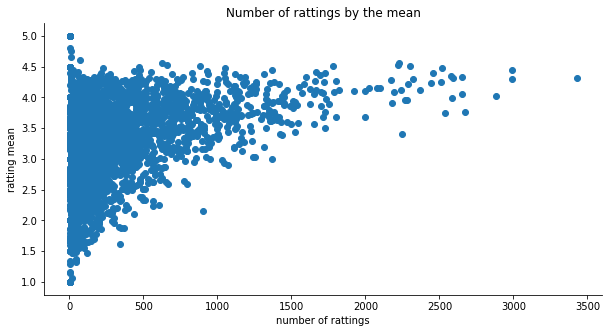

In [8]:
%matplotlib inline  
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
plt.scatter(df_hip1['len'], df_hip1['mean'])
plt.xlabel('number of rattings')
plt.ylabel('ratting mean')
plt.title('Number of rattings by the mean')
sns.despine()

O gráfico demonstra que, quanto maior o número de avaliações, mais concentrada é a média dos filmes, tentendo para valores acima de 4. Logo filmes muito avaliados são, geralmente, bem avaliados, enquanto filmes com poucas avaliações tem alta variação em suas médias.

Podemos verificar o comportamento do desvio padrão também.

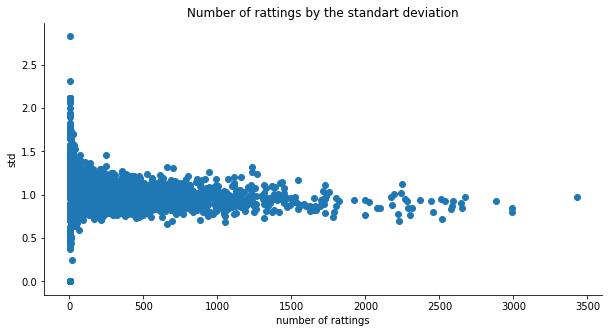

In [159]:
plt.figure(figsize=(10,5))
plt.scatter(df_hip1['len'], df_hip1['std'])
plt.xlabel('number of rattings')
plt.ylabel('std')
plt.title('Number of rattings by the standart deviation')
sns.despine()

Apesar de filmes com mais avaliações terem notas mais altas,ao contrário do que se imaginou, o desvio padrão tende a se normalizar quanto maior o número de reviews. Isso indica que filmes com alto número de avaliações tendem a ter notas altas e consistentes e são bons candidatos para recomendação, enquanto filmes com poucas avaliações tem notas variadas, sendo necessário mais informações para decidir se são boas recomendações.

Podemos validar se o número de avaliações impacta no valor das notas aplicando o teste-t tendo como hipóteses:

- Hipótese nula: O número de avaliações não indica mudança as notas
- Hipótese alternativa: O número de avaliações influencia nas notas

Para definir o que é um alto número de avaliações, verificamos qual a distribuição do número de avaliações por filme.

In [73]:
df_hip1['len'].describe()

count    3706.000000
mean      269.889099
std       384.047838
min         1.000000
25%        33.000000
50%       123.500000
75%       350.000000
max      3428.000000
Name: len, dtype: float64

O número de avaliações por filmes tem um desvio padrão alto, concentrando a maioria dos filmes com menos de 350 avaliações. Para fins de comparação, vamos considerar como um 'alto número de avaliações' a média acrescida de dois desvios padrões (269+(384*2) = 1.037).

In [76]:
from scipy import stats

t, p = stats.ttest_ind(df_hip1.loc[df_hip1['len']>1037, 'mean'],df_hip1.loc[df_hip1['len']<=1037, 'mean'])
print('P value: {}'.format(p))

P value: 2.4470435047055975e-46


Como o valor de p é pequeno, descartamos a hipótese nula e confirmamos a alternativa, que indica que existe sim diferença estatística em filmes com maior número de avaliações.

## 2.2 O sexo do usuário influencia no tipo de filme avaliado

Para essa hipótese podemos separar os filmes de acordo com seu gênero, identificando as notas masculinas e femininas de cada um. Como um filme pode ter mais de um gênero, vamos considerar todo o conjunto de gênero do filme, logo, é possível um filme aparecer em mais de um conjunto.

In [9]:
genres = set(df_movies['genres'].str.split('|').sum())
df_hip2 = {}
for g in genres:
    df_hip2[g] = (
        df_movies.loc[df_movies[g]==1,['movie_id', 'title']]
        .set_index('movie_id')
        .merge(df_ratings
               .merge(df_users, left_on='user_id', right_on='user_id')[['movie_id','rating', 'gender']]
              ,left_index=True, right_on='movie_id')
        
    )

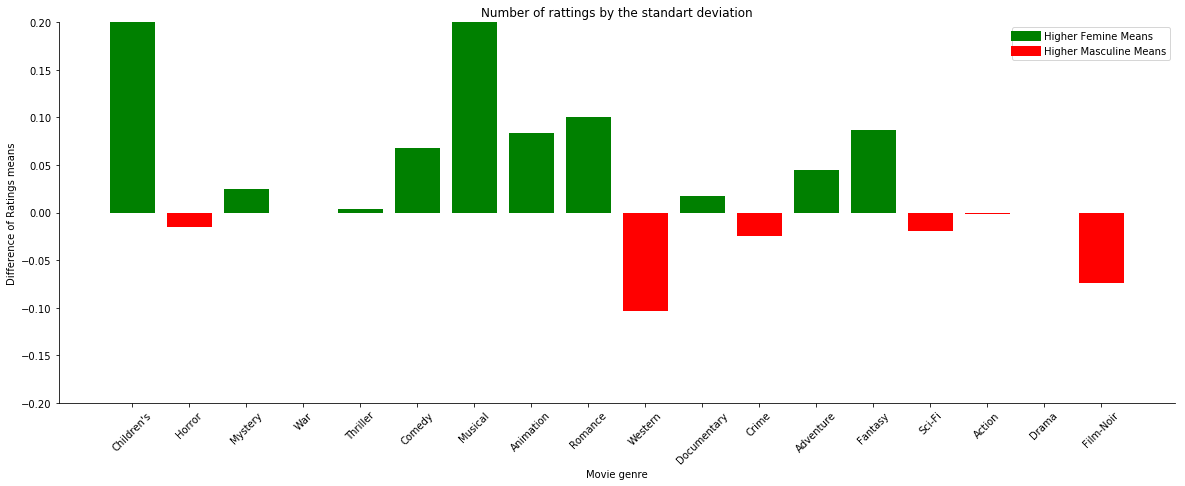

In [53]:
from matplotlib.lines import Line2D
plt.figure(figsize=(20,7))
cmap = plt.cm.get_cmap('tab20')


custom_lines = [Line2D([0], [0], color='green', lw=10),
                Line2D([0], [0], color='red', lw=10)]

avg_grade_f = []
avg_grade_m = []

for enum, g in enumerate(genres):
    df_gen = df_hip2[g]
    avg_grade_f.append(df_gen.loc[df_gen['gender']=='F','rating'].mean())
    avg_grade_m.append(df_gen.loc[df_gen['gender']=='M','rating'].mean())
    ratting_diff= df_gen.loc[df_gen['gender']=='F','rating'].mean()-df_gen.loc[df_gen['gender']=='M','rating'].mean()
    plt.bar(enum, ratting_diff,color=('purple' if ratting_diff > 0 else 'blue'))


ax = plt.gca()
plt.xlabel('Movie genre')
#ax.set_xticklabels(genres)
plt.xticks(range(len(genres)),genres, rotation=45)
plt.ylabel('Difference of Ratings means')
ax.legend(custom_lines, ['Higher Femine Means', 'Higher Masculine Means'])
plt.ylim([-.2,.2])
plt.title('Mean ratting difference between genders of each genre')
sns.despine()

Comparando a diferença entre a média das notas de cada gênero pelos públicos masculinos e feminino, percebe-se que existe sim uma diferença que varia de acordo com o gênero, entretanto, não é um valor altamente significativo. Em uma escala de 1 a 5, a maior diferença entre as médias foi observada em filmes infantis e musicais (diferença de 0.2 pontos). Filmes de ação e drama, gêneros esteriotipados para públicos masculino e feminino, apresentou baixa difenrença entre as notas.

Destaca-se como preferência masculina em frente à feminina filmes de Western e Noir.

Novamente podemos confirmar a hipótese de que as notas diferem de acordo com o gênero usando o T-test com as seguintes hipóteses:

- Hipótese nula: O sexo do usuário não influencia na nota do filme de acordo com seu gênero
- Hipótese alternativa: O sexo do usuário influencia na nota do filme de acordo com seu gênero

In [55]:
from scipy import stats

t, p = stats.ttest_ind(avg_grade_f,avg_grade_m)
print('P value: {}'.format(p))

P value: 0.6207139687508243


Com um p de 0.6 não podemos descartar a hipótese nula, logo, não há comprovação estatística que a nota varia de acordo com o sexo do usuário.

# 3 - Sistema de Recomendação

Existem diversos tipos de sistemas de recomendação diferentes. Vamos testar três abordagens diferentes

- Recomendação de filmes mais assistidos
- Filtro colaborativo baseado em usuário
- Matriz de fatorização

As funções auxiliares abaixo irão servir para executar e testar os algoritmos

In [3]:
def get_random_user_id():
    return df_users['user_id'].sample(1).values[0]

def user_ratings(user_id):
    return df_ratings[df_ratings['user_id']==user_id]

def user_saw_movie(user_id, movie_id):
    return movie_id in user_rattings(user_id)['movie_id'].values

def get_movie_title(movie_id):
    return df_movies.loc[df_movies['movie_id']==movie_id, 'title'].values[0]

Para aplicar alguns algoritmos a seguir vamos selecionar um usuário aleatório e ver os filmes que ele avaliou.

In [4]:
user_id = get_random_user_id()
print('Usuário: {}'.format(user_id))
print('Filmes avaliados:')
print(user_ratings(user_id)['movie_id'].apply(get_movie_title).values)

Usuário: 2088
Filmes avaliados:
['Pawnbroker, The (1965)' 'Who Framed Roger Rabbit? (1988)'
 'Nikita (La Femme Nikita) (1990)' 'Visitors, The (Les Visiteurs) (1993)'
 'Giant Gila Monster, The (1959)' 'Invisible Man, The (1933)'
 'Killer Shrews, The (1959)' 'Phantom of the Opera, The (1943)'
 'Runaway (1984)' 'Honey, I Blew Up the Kid (1992)'
 'Honey, I Shrunk the Kids (1989)' 'Day the Earth Stood Still, The (1951)'
 'Thunderball (1965)' 'Treasure of the Sierra Madre, The (1948)'
 'Stand by Me (1986)' 'Terminator 2: Judgment Day (1991)' 'Jumanji (1995)'
 'Great Escape, The (1963)' 'Diva (1981)' 'Doctor Zhivago (1965)'
 'Rock, The (1996)' 'Manchurian Candidate, The (1962)'
 'Arsenic and Old Lace (1944)' 'Dances with Wolves (1990)'
 'Twister (1996)' 'Barb Wire (1996)' 'Batman (1989)'
 'Wild Bunch, The (1969)' "They Shoot Horses, Don't They? (1969)"
 'Contender, The (2000)' 'Back to the Future (1985)'
 'Cool Hand Luke (1967)' 'Arrival, The (1996)'
 'Taming of the Shrew, The (1967)' '101 Da

## 3.1 Top N filmes

Filmes com muitas visualizações são, normalmente, filmes famosos ou clássicos, servindo de recomendação a todos os usuários, independente de seus gostos. Logo, uma estratégia bem simples e eficiente para recomendar um filme é usar filmes que foram assistidos muitas vezes. Nessa conta simples, basta ordenar os filmes pelo número de avaliações, remover os filmes que o usuário já viu e recomendar os primeiros.

In [7]:
def top_n_itens(user_id, ratings, n_items=10):
        
    return (ratings.loc[~ratings['movie_id']
                        .isin(user_ratings(user_id)['movie_id'].values),'movie_id']
            .value_counts()
            .head(n_items)
            .reset_index()
            .apply(lambda x: get_movie_title(x['index']), axis=1)
    ).values

top_n_itens(user_id, df_ratings)

array(['American Beauty (1999)', 'Silence of the Lambs, The (1991)',
       'Fargo (1996)', 'Sixth Sense, The (1999)',
       "Schindler's List (1993)", 'L.A. Confidential (1997)',
       'Groundhog Day (1993)', 'Being John Malkovich (1999)',
       'Shawshank Redemption, The (1994)', 'Forrest Gump (1994)'],
      dtype=object)

Apesar da vantagem de ser um algoritmo simples, fácil e rápido, ele não é tão personalizável para cada usuário, e acaba não levando em consideração suas preferências pessoais.

## 3.2 Filtro Colaborativo

O filtro colaborativo procura identificar semelhança entre os registros e recomendar outros registros com semelhança parecida. É possível aplicar o filtro colaborativo baseado no usuário ou no gênero. Nesse algoritmo vamos aplicar o filtro baseado no usuário.

Para isso precisamos de uma matriz que relaciona a nota que um usuário deu para cada filme (pivotando a matriz original de notas) e uma medida de similaridade entre vetores, para identificar usuários que deram notas semelhantes para os mesmos filmes e ver quais outros filmes eles gostaram. Será utilizada a similaridade entre cossenos que ignora nota 0 (simbolizando que não viu o filme).

In [8]:
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity

def collaborative_filtering(user_id, ratings, n_items=10, min_similarity_score=0, min_rating=4):
    
    ratings = ratings.pivot_table(index='user_id', columns='movie_id', values='rating').fillna(0)
    similarity = cosine_similarity(ratings[ratings.index==user_id], ratings)        
    similarity_matrix = ratings[(similarity>min_similarity_score)[0]]
    recommedantions = ratings.loc[ratings.index.isin(similarity_matrix.index)].unstack().reset_index(name='rating')                
    recommedantions = recommedantions.loc[(recommedantions['rating']>=min_rating)
                                        &~(recommedantions['movie_id'].isin(user_ratings(user_id)['movie_id'])), 'movie_id'].values                            
    top_recommedantions = Counter(recommedantions)

    return [get_movie_title(x[0]) for x in top_recommedantions.most_common(n_items)]

collaborative_filtering(user_id, df_ratings)

['American Beauty (1999)',
 'Silence of the Lambs, The (1991)',
 'Sixth Sense, The (1999)',
 'Fargo (1996)',
 "Schindler's List (1993)",
 'Shawshank Redemption, The (1994)',
 'L.A. Confidential (1997)',
 'Pulp Fiction (1994)',
 'Being John Malkovich (1999)',
 'Forrest Gump (1994)']

O filtro colaborativo, diferente da primeira abordagem, recomenda itens com perfil mais similar ao do usuário, uma vez que identifica outros usuários com gostos em comum. Acrescentamos um valor mínimo para um usuário ser considerado similar e uma nota mínima que ele deve ter avaliado o filme, para evitar de recomendar filmes que foram mal avaliados.

## 3.3 Fatorização de Matriz

A última técnica aplicada é a fatorização de matriz. Essa técnica identifica variáveis latentes que explicam características dos filmes, como por exemplo seu gênero, para prever a nota que um usuário daria para cada filme. Variáveis latentes são uma forma de redução de dimensionalidade, identificando duas matrizes que, ao se multiplicar, resultam na matriz original. A fatorização de matriz é preferível quando temos uma matriz esparsa com valores faltantes, uma vez que ela tem flexibilidade para lidar com valores faltantes (ao contrário, por exemplo, da SVD, que precisa de uma matriz completa).

In [ ]:
import numpy as np
from sklearn.decomposition import NMF 
    
def matrix_factorization(user_id, ratings, n_items=10, hidden_features=None):
    
    if hidden_features is None:
        hidden_features = int(ratings.shape[0]*0.1)

    ratings = ratings.pivot_table(index='user_id', columns='movie_id', values='rating').fillna(0)
    model = NMF(n_components=hidden_features, init='random', random_state=0)
    W = model.fit_transform(ratings)
    H = model.components_

    ratings_pred = (pd.DataFrame(np.dot(W, H), columns=ratings.columns, index=ratings.index)
                    .unstack()
                    .reset_index(level=0, name='rating')
                    .reset_index()
                   )
    return (ratings_pred[(ratings_pred['user_id']==user_id)
                         &(~ratings_pred['movie_id'].isin(user_ratings(user_id)['movie_id']))
                        ]
            .sort_values('rating')
            .head(n_items)
            ['movie_id'].apply(get_movie_title)
            .values
           )
    

matrix_factorization(user_id, df_ratings)

Neste caso, a recomendação de itens tenta calcular a nota que o usuário daria para cada item, retornando os itens com maior nota. Para melhorar o resultado, é possível aumentar o número de variáveis latentes.

## 4 Avaliação do Sistema de Recomendação

Existem algumas formas de se avaliar um sistema de recomendação. A primeira é retirar algumas avaliações de usuários, rodar a recomendação e verificar se recomendaram os itens faltantes.

Outra forma é, com sistema de avaliações que prevê uma a nota, usar métricas de avaliação de regressão como o r2_score ou RMSE, para avaliar a nota da máquina.

Por fim, pode-se criar novos dados de usuários, pedindo para dar notas em alguns filmes e avaliar as recomendações que o sistema faz a partir dali.

Várias outras técnicas podem ser vistas <a href='https://towardsdatascience.com/evaluation-metrics-for-recommender-systems-df56c6611093' target='blank'>neste link</a>.

# 5 Conclusão e Passos Futuros

Os passos aqui descritos mostram a implementação de 3 tipos de sistemas de recomendação. Existem vários outros sistemas disponíveis como KNN, Apriori, SVD++, etc. Bibliotecas como a Surprise ou a CaseRecommender implementam essas e outrasa técnicas de recomendação.

É possível aprimorar os algoritmos anteriores, principalmente o de fatorização de matriz, otimizando os parâmetros de entrada. Também é possível usar outros tipos de algoritmos de machine learning, aproveitando outras informações dos dados como os gêneros dos filmes, o ano, informações dos usuários, etc.

# 6 Extra

Para facilitar o uso e expansão futura do sistema de recomendação, podemos compilar os tipos de algoritmos em uma mesma classe.

In [110]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF


class MovieLensRecommender(BaseEstimator):
    """
    A recommendation system to recommend movies for users
    

    Parameters
    ----------
    ratings : pandas DataFrame
        Data of users movie ratings 
    movies : pandas DataFrame
        Data of movies
    users : pandas DataFrame
        Data of users
    recommender : String (top_n, collaborative, matrix_factorization)
        Type of recommender algorithm

    Attributes
    -------
    ratings : pandas DataFrame
        Data of users movie ratings 
    movies : pandas DataFrame
        Data of movies
    users : pandas DataFrame
        Data of users
    recommender : String (top_n, collaborative, matrix_factorization)
        Type of recommender algorithm
    pivot_ratings : pandas DataFrame
        Pivot data of movies evaluation
    n_items: int (default 10)
        Number of items to recommend


    """

    
    def __init__(self, ratings, movies, users, recommender='top_n', n_items=10):
        
        self.ratings = ratings
        self.pivot_ratings = ratings.pivot_table(index='user_id', columns='movie_id', values='rating').fillna(0)
        self.movies = movies
        self.users = users
        self.recommender = recommender
        self.n_items = n_items
        self.ratings_pred = None
        

    def get_random_user_id(self):
        return self.users['user_id'].sample(1).values[0]
    

    def user_ratings(self, user_id):
        return self.ratings[self.ratings['user_id']==user_id]
    

    def get_movie_title(self, movie_id):
        return self.movies.loc[self.movies['movie_id']==movie_id, 'title'].values[0]
        

    def fit_predict(self, X, y=None, **kwargs):
        """
        Make recommendations for user

        Parameters
        ----------
        X : int or array
            Student id or student enrollments progress data
        y : pandas DataFrame
            Raw data
        kwargs : dict
            Parameters for the recommendation algorithm

        Returns
        -------
        user_id, recommender : set
            User id with a set of courses recommendations with its score

        """


        if y is not None:
            self.pivot_ratings = y.pivot_table(index='user_id', columns='movie_id', values='rating').fillna(0)
            self.ratings = df_data
        
        if self.recommender == 'top_n':
            return self.top_n_itens(X, **kwargs)  
        
        elif self.recommender == 'collaborative':
            return self.collaborative_filtering(X, **kwargs)  
        
        elif self.recommender == 'matrix_factorization':
            return self.matrix_factorization(X, **kwargs)  
            

    def fit(self, X, y=None, **kwargs):
        """
        Make recommendations for user

        Parameters
        ----------
        X : int or array
            Student id or student enrollments progress data
        y : pandas DataFrame
            Raw data
        kwargs : dict
            Parameters for the recommendation algorithm

        Returns
        -------
        user_id, recommender : set
            User id with a set of courses recommendations with its score

        """

        self.fit_predict(X, y, **kwargs)  
        return self

    def predict(self, X, y=None, **kwargs):
        """
        Make recommendations for user

        Parameters
        ----------
        X : int or array
            Student id or student enrollments progress data
        y : pandas DataFrame
            Raw data
        kwargs : dict
            Parameters for the recommendation algorithm

        Returns
        -------
        user_id, recommender : set
            User id with a set of courses recommendations with its score

        """

        return self.fit_predict(X, y, **kwargs)  
    
    def top_n_itens(self, user_id, n_items=None):
        """
        Recommend top n_items movies to user, removing movies that the user already saw

        Parameters
        ----------
        user_id : int
            user id
        n_items : int
            Number of items to recommend

        Returns
        -------
        recommenders : list
            A list of recommended movies for the user

        """
        
        ratings = self.ratings        
        if n_items is None:
             n_items = self.n_items
        
        return (ratings.loc[~ratings['movie_id']
                            .isin(user_ratings(user_id)['movie_id'].values),'movie_id']
                .value_counts()
                .head(n_items)
                .reset_index()
                .apply(lambda x: get_movie_title(x['index']), axis=1)
        ).values
    
    def collaborative_filtering(self, user_id, n_items=None, min_similarity_score=0, min_rating=4):
        """
        Recommend top n_items movies to user, removing movies that the user already saw

        Parameters
        ----------
        user_id : int
            user id
        n_items : int
            Number of items to recommend
        min_similarity_score : float
            Mininum threshold for a user be consider similar
        min_rating : int (default 4)
            Minimum movie rating for recomendation
        Returns
        -------
        recommenders : list
            A list of recommended movies for the user

        """
    
        if n_items is None:
             n_items = self.n_items
        
        ratings = self.pivot_ratings
        similarity = cosine_similarity(ratings[ratings.index==user_id], ratings)        
        similarity_matrix = ratings[(similarity>min_similarity_score)[0]]
        recommedantions = ratings.loc[ratings.index.isin(similarity_matrix.index)].unstack().reset_index(name='rating')                
        recommedantions = recommedantions.loc[(recommedantions['rating']>=min_rating)
                                            &~(recommedantions['movie_id'].isin(user_ratings(user_id)['movie_id'])), 'movie_id'].values                            
        top_recommedantions = Counter(recommedantions)

        return [get_movie_title(x[0]) for x in top_recommedantions.most_common(n_items)]
    
    def matrix_factorization(user_id, n_items=None, hidden_features=None):
    
        """
        Recommend top n_items movies to user, removing movies that the user already saw

        Parameters
        ----------
        user_id : int
            user id
        n_items : int
            Number of items to recommend
        hidden_features : int 
            Number of hidden for algorithm

        Returns
        -------
        recommenders : list
            A list of recommended movies for the user

        """
        
        
        if n_items is None:
             n_items = self.n_items
    
        if hidden_features is None:
            hidden_features = int(ratings.shape[0]*0.1)
        
        if (self.ratings_pred is None) or (self.model.n_components!=hidden_features):

            ratings = self.pivot_ratings
            self.model = NMF(n_components=hidden_features, init='random', random_state=0)
            W = self.model.fit_transform(ratings)
            H = self.model.components_

            self.ratings_pred = (pd.DataFrame(np.dot(W, H), columns=ratings.columns, index=ratings.index)
                            .unstack()
                            .reset_index(level=0, name='rating')
                            .reset_index()
                           )
        
        return (self.ratings_pred[(ratings_pred['user_id']==user_id)
                             &(~ratings_pred['movie_id'].isin(user_ratings(user_id)['movie_id']))
                            ]
                .sort_values('rating')
                .head(n_items)
                ['movie_id'].apply(get_movie_title)
                .values
               )

In [111]:
mr = MovieLensRecommender(movies=df_movies, ratings=df_ratings, users=df_users, n_items=5)
rand_user = mr.get_random_user_id()

In [115]:
print('Top N Items:')
print(mr.top_n_itens(rand_user))
print('-----------------------------------\n')
print('Filtro Colaborativo:')
print(mr.collaborative_filtering(rand_user))
print('-----------------------------------\n')
print('Fatorização de Matriz:')
print(mr.matrix_factorization(rand_user))
print('-----------------------------------\n')

['Star Wars: Episode V - The Empire Strikes Back (1980)'
 'Star Wars: Episode VI - Return of the Jedi (1983)'
 'Jurassic Park (1993)' 'Saving Private Ryan (1998)' 'Matrix, The (1999)']
['American Beauty (1999)', 'Star Wars: Episode IV - A New Hope (1977)', 'Raiders of the Lost Ark (1981)', 'Silence of the Lambs, The (1991)', 'Sixth Sense, The (1999)']
